In [316]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Unfortunatley, YFinance does not provide the recommendations for all publicly traded companies.
### However, tech stocks and other large companies often work

In [317]:
#Change this variable to the ticker you are interested in analyzing
symbol = "TSLA"
ticker = yf.Ticker(symbol)

In [318]:
df_base = ticker.recommendations.reset_index()
df = df_base.copy()
df['To Grade'].value_counts()

Neutral              56
Buy                  46
Outperform           34
Underperform         30
Hold                 28
Sell                 25
Underweight          23
Overweight           22
Equal-Weight         14
Market Perform        6
Market Outperform     6
Sector Perform        4
                      3
Peer Perform          1
Underperformer        1
Perform               1
Sector Weight         1
In-Line               1
Name: To Grade, dtype: int64

In [319]:
import datetime as dt
df['Date'] = df['Date'].dt.floor('D') # Remove seconds

In [320]:
df['To Grade'] = np.where((df['To Grade']== 'Outperform')|(df['To Grade']== 'Overweight')| (df['To Grade']== 'Strong Buy'),(
'Buy'),df['To Grade']) #Changing terms to Buy

In [321]:
df['To Grade'] = np.where((df['To Grade']== 'Neutral')|(df['To Grade']== 'Market Perform')| (df['To Grade']== 'Equal-Weight'),(
'Hold'),df['To Grade']) #Changing terms to Hold

In [322]:
df['To Grade'] = np.where((df['To Grade']== 'Underweight')|(df['To Grade']== 'Underperform'),(
'Sell'),df['To Grade']) #Changing terms to Sell

In [323]:
df['To Grade'].value_counts()
#Check to make sure there aren't any significant reco types that we forgot to convert

Hold                 104
Buy                  102
Sell                  78
Market Outperform      6
Sector Perform         4
                       3
Sector Weight          1
Peer Perform           1
Underperformer         1
In-Line                1
Perform                1
Name: To Grade, dtype: int64

In [324]:
#Remove any values that are not buy/sell/hold
df = df.loc[(df['To Grade'] == 'Hold')|(df['To Grade']=='Buy')|(df['To Grade']=='Sell')].copy()

In [325]:
prices = yf.download(symbol,interval = '1d', progress=False)

In [326]:
df_buy = df.loc[df['To Grade']=='Buy']
df_sell = df.loc[df['To Grade']=='Sell']

In [327]:
#get buy and sell in prices df so we can scatter plot them on the price plot
plot_buy = prices.merge(df_buy,on='Date', how = 'left')
plot_sell = prices.merge(df_sell,on='Date', how = 'left')

In [328]:
plot_buy = plot_buy.loc[plot_buy['To Grade']=='Buy']
plot_sell = plot_sell.loc[plot_sell['To Grade']=='Sell']

In [329]:
df1 = prices.merge(df, on='Date',how='left')
df1.drop(columns = ['Open','High','Low','Adj Close','Volume','From Grade'],inplace= True)

In [330]:
dt_adj = 261/365 #use to adjust our desired windows

df1['30 day return'] = df1.loc[:,'Close'].pct_change(periods = int(dt_adj*30))
df1['90 day return'] = df1.loc[:,'Close'].pct_change(periods = int(dt_adj*90))
df1['180 day return'] = df1.loc[:,'Close'].pct_change(periods = int(dt_adj*180))
df1['360 day return'] = df1.loc[:,'Close'].pct_change(periods = int(dt_adj*360))
df1['2 year return'] = df1.loc[:,'Close'].pct_change(periods = int(dt_adj*360*2))
df1['3 year return'] = df1.loc[:,'Close'].pct_change(periods = int(dt_adj*360*3))
df1['5 year return'] = df1.loc[:,'Close'].pct_change(periods = int(dt_adj*360*5))

In [331]:
df1['30 day return'] = df1['30 day return'].shift(-int(dt_adj*30))
df1['90 day return'] = df1['90 day return'].shift(-int(dt_adj*90))
df1['180 day return'] = df1['180 day return'].shift(-int(dt_adj*180))
df1['360 day return'] = df1['360 day return'].shift(-int(dt_adj*360))
df1['2 year return'] = df1['2 year return'].shift(-int(dt_adj*360*2))
df1['3 year return'] = df1['3 year return'].shift(-int(dt_adj*360*3))
df1['5 year return'] = df1['5 year return'].shift(-int(dt_adj*360*5))

In [332]:
#Need to format df so that it can be used in a boxplot
return_gp = df1.groupby(['To Grade','Firm']).mean().reset_index()
return_gp.drop(columns = 'Close',inplace=True)

return_melt = return_gp.melt(id_vars=['To Grade','Firm'])
return_melt_short = return_melt.loc[(return_melt['variable']=='30 day return')|
                                    (return_melt['variable']=='90 day return')|
                                    (return_melt['variable']=='180 day return')|
                                    (return_melt['variable']=='360 day return')]

return_melt_long = return_melt.loc[(return_melt['variable']=='2 year return')|
                                    (return_melt['variable']=='3 year return')|
                                   (return_melt['variable']=='5 year return')|
                                    (return_melt['variable']=='360 day return')]

### Uncomment and change the datemin and datemax variables to zoom in on certain dates

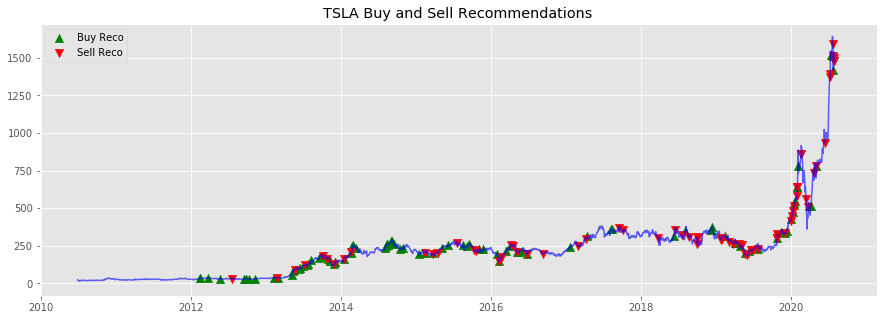

In [333]:
fig = plt.figure(figsize = (15,5))
plt.style.use('ggplot')

#variables for plot to make tweaking easier
line_alpha = 0.6
marker_alpha = 1
line_color = 'b'
buy_color = 'g'
sell_color = 'r'
marker_s = 70

ax = plt.subplot(1,1,1)
plt.plot(prices.index, prices.Close, color =line_color, alpha=line_alpha)
plt.scatter(x = plot_buy.Date, y = plot_buy.Close, color = buy_color, marker = '^', label = 'Buy Reco',s=marker_s, alpha = marker_alpha)
plt.scatter(x = plot_sell.Date, y = plot_sell.Close, color = sell_color, marker = 'v', label = 'Sell Reco',s=marker_s, alpha=marker_alpha)
plt.title('{} Buy and Sell Recommendations'.format(symbol))
plt.legend(loc=2)

#datemin = dt.date(2018, 7, 1)
#datemax = dt.date(2020, 7, 24)
#ax.set_xlim(datemin, datemax)

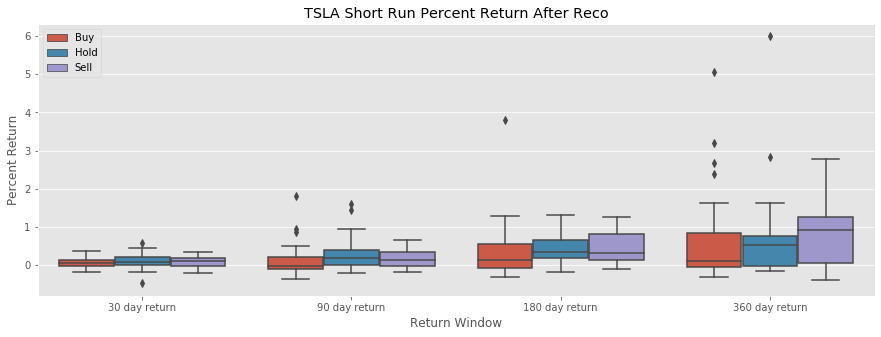

In [334]:
plt.figure(figsize = (15,5))


sns.boxplot(x='variable',y = 'value', hue = 'To Grade',data = return_melt_short)
plt.title('{} Short Run Percent Return After Reco'.format(symbol))
plt.ylabel('Percent Return')
plt.xlabel('Return Window')
plt.legend(loc = 2)

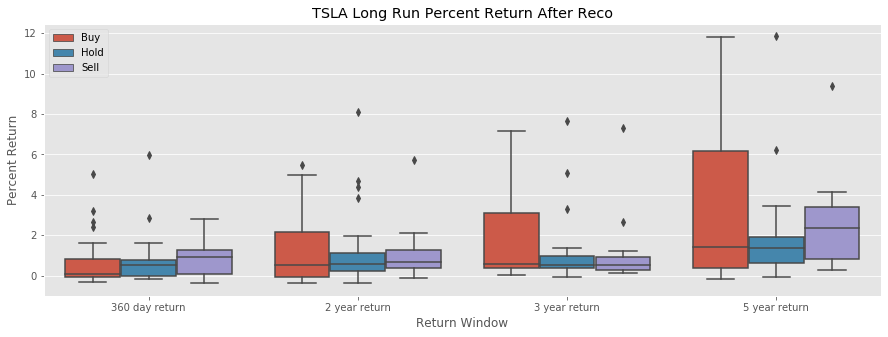

In [335]:
plt.figure(figsize = (15,5))
sns.boxplot(x='variable',y = 'value', hue = 'To Grade',data = return_melt_long)
plt.title('{} Long Run Percent Return After Reco'.format(symbol))
plt.ylabel('Percent Return')
plt.xlabel('Return Window')
plt.legend(loc = 2)